# Lab 2 - Sentiment analysis in textual movie review

First, a few tactical imports :

In [91]:
# Authors: Alexandre Gramfort
#          Chloe Clavel
# License: BSD Style.
# TP Cours ML Telecom ParisTech MDI343

import os.path as op
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score


In [92]:
###############################################################################
# Load data
print("Loading dataset")

from glob import glob
filenames_neg = sorted(glob(op.join('data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(op.join('data', 'imdb1', 'pos', '*.txt')))

texts_neg = [open(f).read() for f in filenames_neg]
texts_pos = [open(f).read() for f in filenames_pos]
texts = texts_neg + texts_pos
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))

Loading dataset
2000 documents


### Question 1

In [93]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts

    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """
    words = set()
    vocabulary = dict()
    for text in texts:
        textList = text.split(" ")
        for w in textList:
            words.add(w)
    n_features = len(words)
    vocabulary = {key: value for (value, key) in enumerate(words)}
    counts = np.zeros((len(texts), n_features))
    for i in range(len(texts)):
        textList = texts[i].split(" ")
        for w in textList:
            counts[i][vocabulary[w]] += 1
    return vocabulary, counts

### Question 2

To assign positive and negative classes to the reviews, they attempted to distinguish a mark or a numerical rating (remark : a rating with a letter is a numerical rating that does not admit its essence). 

A file's classification is determined based on the first rating they were able to identify.

Above the average was considered as positive, the average or less was considered negative.

### Question 3

In [94]:
class NB(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        N = X.shape[0]
        n_features = X.shape[1]
        self.classes = set(y)
        self.prior = np.zeros((len(self.classes),))
        self.p = np.zeros((n_features, len(self.classes)))
        for i, elt in enumerate(self.classes):
            Xc = np.array([[0 for k in range(n_features)] for j in range(list(y).count(elt))])
            Nc = 0
            for j in range(N):
                if y[j] == elt:
                    Xc[Nc,:] = X[j,:]
                    Nc += 1
            self.prior = Nc * 1. / N
            T = np.array([np.sum(Xc[:,j]) for j in range(n_features)])
            
            somme = 0
            #calc tct'
            for j in range(n_features):
                self.p[j][i] = T[j] + 1
                somme += T[j] + 1
                
            for j in range(n_features):
                self.p[j][i]= self.p[j][i] * 1. / somme
                
        return self
        

    def predict(self, X):
        score = np.dot(X, np.log(self.p))
        score += np.log(self.prior)
        res = np.array([0,1])[np.argmax(score, axis = 1)]
        return res
        
    def score(self, X, y):
        return np.mean(self.predict(X) == y)
        
# Count words in text
vocabulary, X = count_words(texts)

# Try to fit, predict and score
nb = NB()
nb.fit(X[::2], y[::2])
print(nb.score(X[1::2], y[1::2]))

0.829


### Question 4

In [95]:
score = cross_val_score(nb, X, y, cv=5)
print("score : ", score)

score :  [0.805  0.835  0.8225 0.825  0.8025]


In [96]:
myNbRes = score

### Question 5

In [97]:
stop_file = open("data/english.stop.txt", "r")

stop_words = stop_file.read().split("\n")

stop_file.close()

def count_words_stop(texts):
    words = set()
    vocabulary = dict()
    for text in texts:
        textList = text.split(" ")
        for w in textList:
            if w not in stop_words:
                words.add(w)
    n_features = len(words)
    vocabulary = {key: value for (value, key) in enumerate(words)}
    counts = np.zeros((len(texts), n_features))
    for i in range(len(texts)):
        textList = texts[i].split(" ")
        for w in textList:
            if w not in stop_words:
                counts[i][vocabulary[w]] += 1
    return vocabulary, counts

In [98]:
vocabulary2, X2 = count_words_stop(texts)

score2 = cross_val_score(nb, X2, y, cv=5)
print(score2)

[0.8    0.8225 0.815  0.8225 0.7825]


In [99]:
myNbResStopWord = score2

The results don't really improve by ignoring the stop words. However, when we look at the stop words list, we see that it contains words such as "like", "liked", "last", "unfortunately" or "zero" which are obviously words that we want to keep (words that suggests that the review is positive or negative). We should try with another stop words list.

#### Scikit - learn use

**Question 1**

In [100]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import os.path as op
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from glob import glob
import re
import pandas as pd
import operator
import unittest
import sys
import operator
from sklearn.model_selection import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.base import BaseEstimator, ClassifierMixin


In [101]:
nb_pipline = Pipeline([('count', CountVectorizer()), ('nb', MultinomialNB())])
skNbRes = cross_val_score(nb_pipline.set_params(count__analyzer='word'), texts, y, cv=5)
skNbBigramRes = cross_val_score(nb_pipline.set_params(count__analyzer='word', count__ngram_range=(1, 2)), texts, y, cv=5)
skNbResStopWord = cross_val_score(nb_pipline.set_params(count__analyzer='word', count__ngram_range=(1,1), count__stop_words='english'), texts, y, cv=5)
skNbBigramResStopWord = cross_val_score(nb_pipline.set_params(count__analyzer='word', count__ngram_range=(2, 2), count__stop_words='english'), texts, y, cv=5)

In [ ]:
data_nb = [myNbRes, myNbResStopWord,skNbRes,skNbBigramRes, skNbResStopWord, skNbBigramResStopWord]
label = ['my NB','my NB with stop words','NB', 'NB with bigram', 'NB with stop words', 'NBw with bigram and stop words']

plt.figure(figsize=(12,8))

x = [np.mean(data_nb[j]) for j in range (len(my_nb_res)+1)]

plt.bar(label, x)
plt.title("cross_val_scores")

plt.plot()

That shows that our implementation is acceptable, as it has a result really close to  a NB with bigram, which is the best one.

## **Question 2**

In [103]:
from sklearn.svm import LinearSVC
svc_pipline = Pipeline([('count', CountVectorizer()), ('svc', LinearSVC())])
svcNbRes = cross_val_score(svc_pipline.set_params(count__analyzer='word'), texts, y, cv=5)
svcNbBigramRes = cross_val_score(svc_pipline.set_params(count__analyzer='char_wb', count__ngram_range=(2, 2)), texts, y, cv=5)
svcNbResStopWord = cross_val_score(svc_pipline.set_params(count__analyzer='word', count__ngram_range=(1, 1), count__stop_words='english'), texts, y, cv=5)
svcNbBigramResStopWord = cross_val_score(svc_pipline.set_params(count__analyzer='char_wb', count__ngram_range=(2, 2), count__stop_words='english'), texts, y, cv=5)

[]

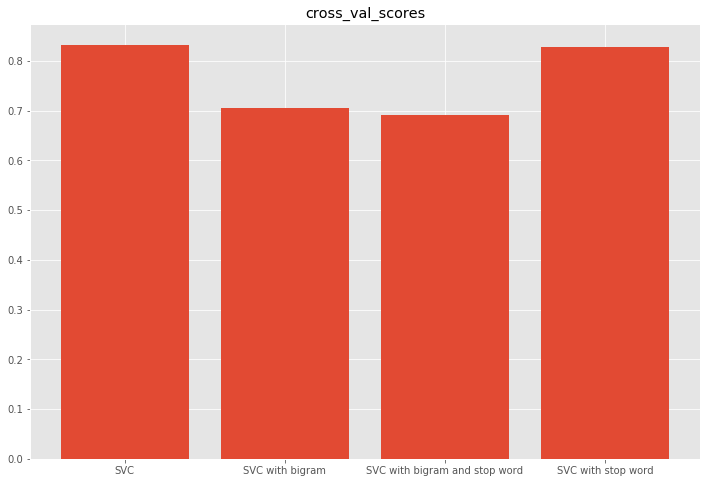

In [104]:
label = ['SVC', 'SVC with bigram', 'SVC with stop word', 'SVC with bigram and stop word']
data_svc = [svcNbRes, svcNbBigramRes,svcNbResStopWord, svcNbBigramResStopWord]

plt.figure(figsize=(12,8))

x = [np.mean(data_svc[j]) for j in range (len(data_svc))]
plt.bar(label, x)
plt.title("cross_val_scores")

plt.plot()

We find out that the SVC alone is way better than with a bigram, and that the use of stop words does not affect the results. 

## **Question 3**

In [105]:
from nltk import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

In [109]:
stemmer = SnowballStemmer("english")

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

nbStemPipeline = Pipeline([('count', StemmedCountVectorizer()),('mnb', MultinomialNB())])
nbStemScore = np.mean(cross_val_score(nbStemPipeline, texts, y, cv=5))

svcStemSipline = Pipeline([('count', StemmedCountVectorizer()),('svc', LinearSVC())])
svcStemScore = np.mean(cross_val_score(svcStemSipline, texts, y, cv=5))

[]

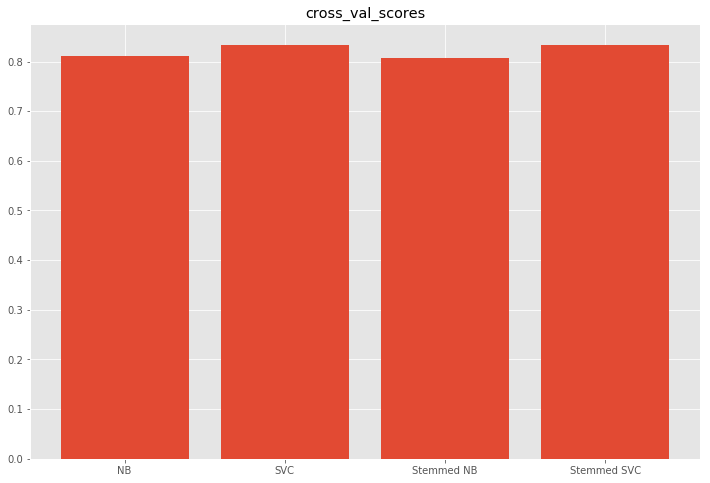

In [111]:
label = ['NB', 'Stemmed NB', 'SVC', 'Stemmed SVC']
dataStem = [skNbRes, nbStemScore,svcNbRes, svcStemScore]

plt.figure(figsize=(12,8))

x = [np.mean(data_svc[j]) for j in range (len(dataStem))]
plt.bar(label, x)
plt.title("cross_val_scores")

plt.plot()

We obtain that the stemming does not change the result.

## **Question 4**

In [113]:
from nltk import pos_tag
from nltk import word_tokenize
nltk.download('universal_tagset')

def filterPos(texts=texts):
    filtered = [list(filter(lambda x: (x[1] == 'NOUN') 
                         or (x[1] == 'VERB') 
                         or (x[1] == 'ADV') 
                         or (x[1] == 'ADJ'), pos_tag(word_tokenize(txt), tagset='universal'))) for txt in texts]
    return filtered

def applyPosTag(filtered):
    postagged = []
    for i, tuples in enumerate(filtered, 0):
        postagged.append('')
        for t in tuples:
            postagged[i] += t[0] + ' '
    return postagged

postText = applyPosTag(filterPos())

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/Raph/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [115]:
nbPipeline = Pipeline([('count', CountVectorizer()), ('svc', MultinomialNB())])
nbPosTagScore = np.mean(cross_val_score(nbPipeline, postText, y))

svcPipeline = Pipeline([('count', CountVectorizer()),('svc', LinearSVC())])
svcPosTagScore = np.mean(cross_val_score(svcPipeline, postText, y))

[]

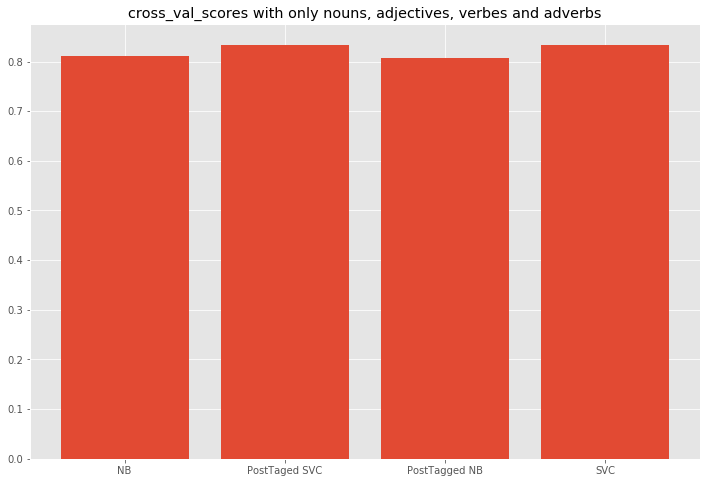

In [116]:
dataTag = [skNbRes, nbPosTagScore,svcNbRes, svcPosTagScore]
label = ['NB', 'PostTagged NB', 'SVC', 'PostTaged SVC']

plt.figure(figsize=(12,8))

x = [np.mean(data_svc[j]) for j in range (len(dataTag))]
plt.bar(label, x)
plt.title("cross_val_scores with only nouns, adjectives, verbes and adverbs")

plt.plot()

We hereby obtain that the post tagging does not affect the result either. 